# AutoML and Timeseries Meetup - Hands On

https://github.com/NeuralAlgorithms/firefly-tutorials/tree/master/meetup_automl_timeseries


## Setup

In [73]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.linear_model import RidgeCV, ARDRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from tsfresh.feature_extraction.feature_calculators import mean, variance, number_peaks, approximate_entropy, median, \
    fft_coefficient, cwt_coefficients,  autocorrelation

## Example Time Series Data Set

Average time step: 0 days 01:00:00


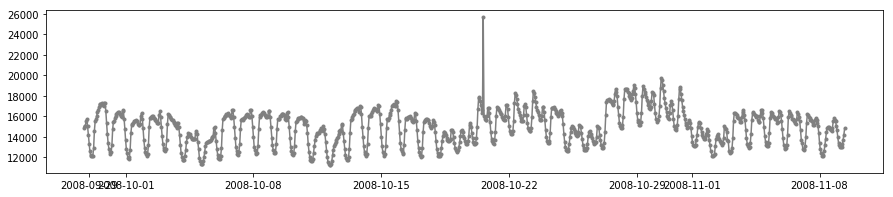

In [147]:
start_sample = 35000
end_sample = 36000

df = pd.read_csv('data/AEP_hourly.csv', parse_dates=['Datetime'])

# sort dates ascending
df = df.set_index(['Datetime'])
df = df.sort_index()
df = df.reset_index()

t = df.Datetime[start_sample:end_sample]
y = df.AEP_MW[start_sample:end_sample]

plt.figure(figsize=(15,3))
plt.plot(t, y, '.-', c='gray')

t_diff_median = t.diff().median()
print('Average time step: {!s}'.format(t_diff_median))

## Fitting a Model

In [140]:
def fit_model(t, X, y, test_size=0.2, estimator=None, plot=False):
    # apply forecast distance
    #     X = X.shift(distance)

    # ignore missing value rows
    #     non_null = X.dropna(how='any').index.values

    # create holdout set
    if isinstance(test_size, float):
        test_size = int(test_size * len(t))
    t_train = t[:-test_size]
    t_test = t[-test_size:]
    x_train = X[:-test_size]
    x_test = X[-test_size:]
    y_train = y[:-test_size]
    y_test = y[-test_size:]

    #     # standardize
    #     numeric_cols = X.select_dtypes(include=[np.number]).columns
    #     centers = X.loc[train, numeric_cols].mean(axis=0)
    #     scales = np.maximum(1e-15, X.loc[train, numeric_cols].std(axis=0))
    #     X[numeric_cols] = (X[numeric_cols] - centers)/scales

    # fit model
    if estimator is None:
        #         estimator = ElasticNetCV(n_alphas=100, l1_ratio=0.9, cv=5, random_state=123)
        estimator = RidgeCV(cv=5)

    #     estimator.fit(X.loc[train, :], y[train])
    estimator.fit(x_train, y_train)

    test_score = estimator.score(x_test, y_test)

    # plot the fit
    if plot:
        plt.figure(figsize=(9, 3))
        plt.plot(t, y, '.', c='gray', alpha=0.7)
        plt.plot(t_train, estimator.predict(x_train), 'b-', lw=2, alpha=0.7)
        plt.plot(t_test, estimator.predict(x_test), 'r-', lw=2, alpha=0.7)
        plt.annotate('Test Score: {}'.format(test_score),
                     xy=(0, 1), xytext=(12, -12), va='top',
                     xycoords='axes fraction', textcoords='offset points')
        plt.show()
    return estimator, test_score


def feature_importance_summary(model, columns):
    if hasattr(model, 'coef_'):
        coef = pd.Series(model.coef_, index=columns, name='Importance')
        importances = coef.abs()
        importances.sort_values(ascending=False, inplace=True)
        importances = importances[importances > 1e-15]
        display(importances.to_frame().style.bar())
    else:
        raise NotImplemented('Only linear models supported at the momemnt.')


class MultiplicativeEstimator(BaseEstimator, RegressorMixin):

    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y, *args, **kwargs):
        self.estimator.fit(X, np.log(y), *args, **kwargs)
        return self

    def predict(self, X):
        return np.exp(self.estimator.predict(X))

    def __getattr__(self, name):
        return getattr(self.estimator, name)

In [148]:
window = 48
_mean = []
_median = []
_variance = []
_entropy = []
_peaks = []
_autocorrelation = []
dates = []
values = []
df_sub = df[start_sample:end_sample].copy()
df_sub.index -= start_sample
series_size = end_sample - start_sample
for i in range(window+1, series_size):
    dates.append(df_sub.Datetime[i])
    values.append(df_sub.AEP_MW[i])
    _mean.append(mean(df_sub.AEP_MW[i-window:i]))
    _median.append(median(df_sub.AEP_MW[i-window:i]))
    _variance.append(variance(df_sub.AEP_MW[i-window:i]))
    _peaks.append(number_peaks(df_sub.AEP_MW[i-window:i], 3))
    _entropy.append(approximate_entropy(df_sub.AEP_MW[i-window:i], 10, 0.7))
    _autocorrelation.append(autocorrelation(df_sub.AEP_MW[i-window:i], 1))


# lags
lags = {}
n_lags = 20
for i in range(1,n_lags):
    lags[i] = df_sub.AEP_MW.shift(i)
    

df_lags = df_sub.copy()

for i in range(1,n_lags):
    df_lags['lag' + str(i)] = 0

for i in range(1,n_lags):
    df_lags['lag' + str(i)] = lags[i]

# df_lags = df_lags.dropna()


df_features = df_lags.copy()

# additional statistical features
df_features['mean'] = 0
df_features['median'] = 0
df_features['variance'] = 0
df_features['entropy'] = 0

df_features.AEP_MW = df_features.AEP_MW.astype(int)
print(df_features.shape)
print(len(_mean))
df_features['mean'][window+1:series_size] = np.asarray(_mean)
df_features['median'][window+1:series_size] = np.asarray(_median)
df_features['variance'][window+1:series_size] = np.asarray(_variance)
df_features['entropy'][window+1:series_size] = np.asarray(_entropy)

df_features = df_features.dropna()


df_train = df_features[window + 1:series_size]
df_train


(1000, 25)
951


,Datetime,AEP_MW,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,...,lag14,lag15,lag16,lag17,lag18,lag19,mean,median,variance,entropy
68,2008-10-01 13:00:00,15571,15521.0,15574.0,15360.0,15210.0,15137.0,14358.0,12733.0,12033.0,...,14800.0,15772.0,16573.0,16509.0,15971.0,16072.0,15146.437500,15557.5,2.983498e+06,0.085129
69,2008-10-01 14:00:00,15622,15571.0,15521.0,15574.0,15360.0,15210.0,15137.0,14358.0,12733.0,...,13659.0,14800.0,15772.0,16573.0,16509.0,15971.0,15118.250000,15556.0,2.920631e+06,0.087030
70,2008-10-01 15:00:00,15515,15622.0,15571.0,15521.0,15574.0,15360.0,15210.0,15137.0,14358.0,...,12782.0,13659.0,14800.0,15772.0,16573.0,16509.0,15086.333333,15556.0,2.838560e+06,0.069180
71,2008-10-01 16:00:00,15256,15515.0,15622.0,15571.0,15521.0,15574.0,15360.0,15210.0,15137.0,...,12384.0,12782.0,13659.0,14800.0,15772.0,16573.0,15050.895833,15531.0,2.746643e+06,0.057398
72,2008-10-01 17:00:00,15176,15256.0,15515.0,15622.0,15571.0,15521.0,15574.0,15360.0,15210.0,...,11883.0,12384.0,12782.0,13659.0,14800.0,15772.0,15012.375000,15518.0,2.658133e+06,0.058894
73,2008-10-01 18:00:00,15135,15176.0,15256.0,15515.0,15622.0,15571.0,15521.0,15574.0,15360.0,...,11823.0,11883.0,12384.0,12782.0,13659.0,14800.0,14967.312500,15496.5,2.543885e+06,0.082284
74,2008-10-01 19:00:00,15254,15135.0,15176.0,15256.0,15515.0,15622.0,15571.0,15521.0,15574.0,...,12033.0,11823.0,11883.0,12384.0,12782.0,13659.0,14925.854167,15419.0,2.445760e+06,0.087314
75,2008-10-01 20:00:00,16053,15254.0,15135.0,15176.0,15256.0,15515.0,15622.0,15571.0,15521.0,...,12733.0,12033.0,11823.0,11883.0,12384.0,12782.0,14889.583333,15352.5,2.357493e+06,0.093130
76,2008-10-01 21:00:00,16331,16053.0,15254.0,15135.0,15176.0,15256.0,15515.0,15622.0,15571.0,...,14358.0,12733.0,12033.0,11823.0,11883.0,12384.0,14862.979167,15352.5,2.260908e+06,0.089890
77,2008-10-01 22:00:00,15774,16331.0,16053.0,15254.0,15135.0,15176.0,15256.0,15515.0,15622.0,...,15137.0,14358.0,12733.0,12033.0,11823.0,11883.0,14842.125000,15352.5,2.178370e+06,0.101371


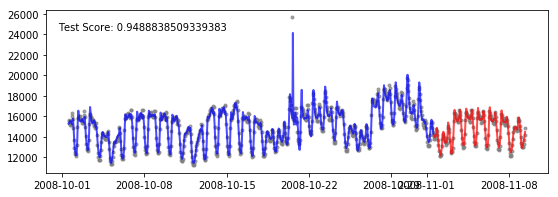

,Importance
lag1,0.903616
lag2,0.13247
lag19,0.127253
lag10,0.118082
lag11,0.106241
lag8,0.0997083
lag7,0.0981385
lag15,0.0895086
lag18,0.0834933
lag14,0.0729699


In [149]:
t = df_train.Datetime
X = df_train.drop(['Datetime', 'AEP_MW', 'entropy'], axis=1)
y = df_train.AEP_MW

# fit
model, score = fit_model(t.values, X.values, y.values, plot=True)

# display importances
feature_importance_summary(model, X.columns)

# fit
# model, score = fit_model(t.values, X.values, y.values, plot=True, distance=12, estimator=RandomForestRegressor())

# display importances
# feature_importance_summary(model, X.columns)

## Number of Lags

Text(0, 0.5, 'Test Score')

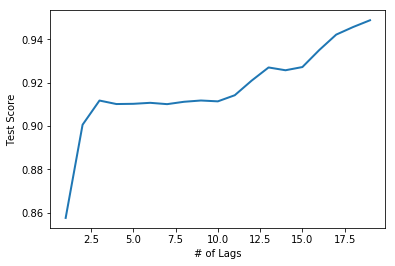

In [150]:
t = df_train.Datetime
y = df_train.AEP_MW

scores = []
lag_count = []
for i in range(1,n_lags):
    drop_columns = ['Datetime', 'AEP_MW', 'entropy']
    for l in range(1,i):
        drop_columns.append('lag' + str(n_lags-l))
        
    X = df_train.drop(drop_columns, axis=1)
    
    # fit
    model, score = fit_model(t.values, X.values, y.values, plot=False)
    scores.append(score)
    lag_count.append(n_lags-i)
    
plt.figure()
plt.plot(lag_count, scores, lw=2)
plt.xlabel('# of Lags')
plt.ylabel('Test Score')


## Log Transform / Differencing

Text(0, 0.5, 'Differenced and Log Transformed')

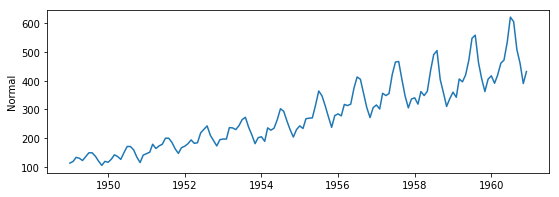

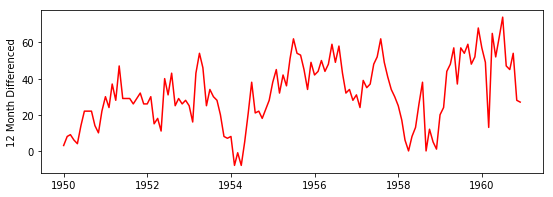

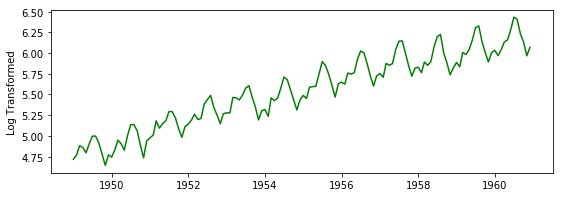

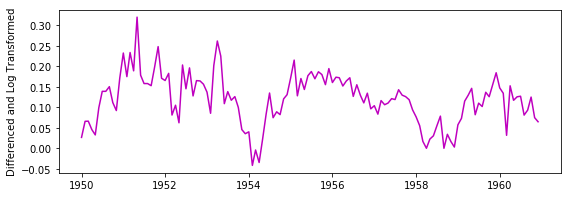

In [9]:
# read the data
data = pd.read_csv('data/air_passengers.csv', parse_dates=['date'])
t = data['date']
y = data['y']

# normal
plt.figure(figsize=(9,3))
plt.plot(t, y)
plt.ylabel('Normal')

# differencing
plt.figure(figsize=(9,3))
plt.plot(t, y - y.shift(12), 'r')
plt.ylabel('12 Month Differenced')

# log transform
log_y = y.apply(np.log)
plt.figure(figsize=(9,3))
plt.plot(t, log_y, 'g');
plt.ylabel('Log Transformed')

# both
plt.figure(figsize=(9,3))
plt.plot(t, log_y - log_y.shift(12), 'm')
plt.ylabel('Differenced and Log Transformed')
